<table>
    <tr>
        <th><img src="img/rqc.png" href="http://www.rqc.ru/" width="150px"></th>
        <th colspan="3" align=left style="font-weight:normal">
            <p>• Anton Karazeev: <a href="mailto:a.karazeev@rqc.ru">a.karazeev@rqc.ru</a> or <a href="https://t.me/akarazeev">t.me/akarazeev</a></p>
            <p>• Based on <a href="https://github.com/QISKit/qiskit-tutorial">QISKit Tutorial</a></p>
            <p>• The latest version of this notebook is available <a href="https://github.com/RQC-QApp/Seminars">here</a></p>
        </th>
    </tr>
</table>

# IBM Q Experience
## Введение

In [10]:
# Подключаем необходимые методы/классы/etc.
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute

# Указываем необходимое число квантовых регистров (кубитов)
# и классических регистров.
# 
# В обоих случаях указано 2. Помимо количества им присваиваются идентификаторы
# в рамках программы `qp`: "qr" и "cr" соответственно.
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(2, name="cr")

# Создаём квантовую цепь с квантовыми регистрами `qr`, классическими регистрами `cr` и называем её "Bell".
qc = QuantumCircuit(qr, cr, name="Bell")

# Начинаем добавлять различные гейты (операции над кубитами).
# 
# Синтаксис следующий:
# "<квантовая_цепь>.<гейт>(<квантовый/классический регистр, параметры, etc. - в зависимости от гейта>)".

# Гейт Адамара на нулевой кубит.
qc.h(qr[0])
# Controlled NOT (CNOT) гейт, который использует `qr[0]` кубит как управляющий, а кубит `qr[1]` как таргет.
qc.cx(qr[0], qr[1])
# Измерить кубиты и записать измеренные значения в классические регистры.
qc.measure(qr, cr)

# Скомпилировать и запустить выполнение программы
# "Bell" на бэкэнде "local_qasm_simulator".
job_sim = execute(qc, "local_qasm_simulator")
result = job_sim.result()

# Посмотреть на результаты программы в виде "{'00': n1, '01': n2, ...}", где n1, n2, ... - число
# соответствующих исходов.
print(result.get_counts("Bell"))

{'00': 496, '11': 528}


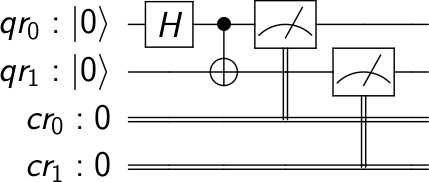

In [32]:
from qiskit.tools.visualization import circuit_drawer

# Изобразим квантовую цепь, которая соответствует "Bell".
circuit_drawer(qc)

Построенная квантовая цепь "Bell" соответствует <b>Белловскому состоянию</b>: $|\Phi^+\rangle = \frac{1}{\sqrt{2}}\left( |00\rangle + |11\rangle \right)$. Его называют максимально запутанным состоянием двух кубит.

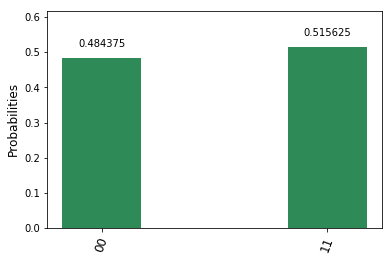

In [33]:
from qiskit.tools.visualization import plot_histogram

# Гистограмма распределения исходов.
plot_histogram(result.get_counts('Bell'))

In [34]:
# Посмотреть на программу в представлении OpenQASM - Open Quantum Assembly Language. Этот язык используется
# для описания инструкций к квантовой машине.
print(qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];
h qr[0];
cx qr[0],qr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];



## Запуск на реальном устройстве

До этого программа запускалась на локальном симуляторе ("local_qasm_simulator"). Теперь же запустим на реальном квантовом чипе в облаке.

Для этого понадобится файл `Qconfig.py`, в котором должно находиться следующее:

```python
    APItoken = <YOUR API TOKEN>

    config = {
        'url': 'https://quantumexperience.ng.bluemix.net/api',
        # The following should only be needed for IBM Q users.
        'hub': 'MY_HUB',
        'group': 'MY_GROUP',
        'project': 'MY_PROJECT'
    }
```

Токен необходимо взять на сайте Q Experience: [IBMQX](https://quantumexperience.ng.bluemix.net) -> `My Account` -> `Advanced` -> `Copy API Token` (либо же сначала `Regenerate`).

In [36]:
from qiskit import register
import Qconfig

# Указываем APItoken и ссылку на соответствующий API.
qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']
}
print('Qconfig loaded from %s.' % Qconfig.__file__)

# Регистрируемся в системе IBM Q.
register(qx_config['APItoken'], qx_config['url'])

Qconfig loaded from /Users/AntonKarazeev/WD/QUANTUM/Seminars/02_IBM_QISKit/Qconfig.py.


In [37]:
from qiskit import available_backends

# Список облачных устройств, которые подключены к сети.
available_backends({'local': False})

['ibmqx5', 'ibmqx4', 'ibmqx2', 'ibmq_qasm_simulator']

In [39]:
from qiskit import get_backend

# По названию устройства можно проверить его статус.
get_backend('ibmqx5').status

{'available': True, 'name': 'ibmqx5', 'pending_jobs': 0}

In [49]:
# Следующими строками можно найти доступный в настоящий момент времени квантовое устройство, которое имеет 16 кубит.
#
# Составляем список из всех облачных бэкэндов (симуляторы не рассматриваем, потому что у них нет параметра 'n_qubits').
backends = available_backends({'local': False})

real_device_backend = [backend for backend in backends if
                       get_backend(backend).configuration['n_qubits'] == 16 and
                       get_backend(backend).status['available'] == True]
real_device_backend

['ibmqx5']

In [58]:
backend = real_device_backend[0]

# Список из квантовых схем, которые хочется запустить на квантовом устройстве. Здесь
# может быть перечислено несколько схем, это будет оптимальнее запускать на сервере
# в том плане, что на сервере есть очередь на запуск.
circuits = [qc]

# Количество "запусков" программы на бэкэнде. Максимальное число равно 8192.
shots = 1024
# Максимальное число кредитов, которые вы готовы потратить за запуск программы.
max_credits = 5

In [59]:
# Отпраляем программу в облако и ожидаем выполнения.

job = execute(circuits, backend=backend, shots=shots,
              max_credits=max_credits)
result_real = job.result()

In [84]:
# Проверяем статус программы.
result_real.get_status()

'COMPLETED'

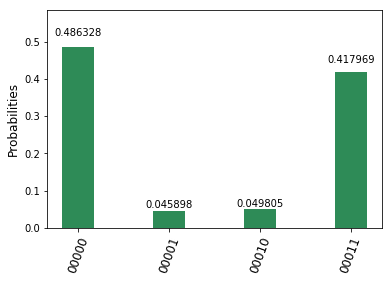

In [86]:
%%time
# Гистограмма распределения исходов на настоящем квантовом устройстве.
plot_histogram(result_real.get_counts('Bell'))

Про кредиты:

<img src='img/shots.jpg' width="250px">

<p style="text-align: center;"><a href="https://quantumexperience.ng.bluemix.net/qx/editor">Source</a></p>

## Реализация квантовых цепей

<img src="img/circuits.jpg" width="250px">

### Начнем с первой цепи

In [89]:
qc_1 = qp.create_circuit('qc_1', [qr], [cr])
qc_1.measure(qr[0], cr[0])

# Теперь заметим, что квантовая цепь "qc_1" добавилась к остальным.
qp.get_circuit_names()

dict_keys(['Bell', 'qc_1'])

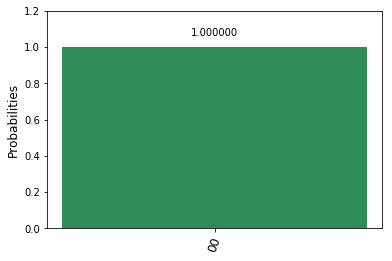

In [92]:
# Запустим на локальном симуляторе и построим гистограмму исходов.
result = qp.execute('qc_1')
plot_histogram(result.get_counts('qc_1'))

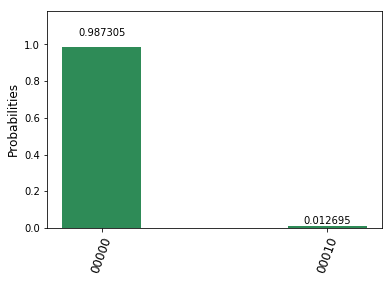

In [94]:
%%time
# Запустим ту же цепь на реальном устройстве.
result_real = qp.execute('qc_1', backend=backend,
                         shots=shots, max_credits=max_credits,
                         wait=wait_time, timeout=timeout)
plot_histogram(result_real.get_counts('qc_1'))

### Вторая цепь

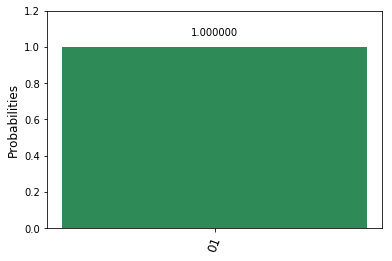

In [97]:
qc_2 = qp.create_circuit('qc_2', [qr], [cr])
# Добавляем NOT-гейт.
qc_2.x(qr[0])
qc_2.measure(qr[0], cr[0])

result = qp.execute('qc_2')
plot_histogram(result.get_counts('qc_2'))

Можно заметить как "флипнулся" первый кубит.

### Третья цепь

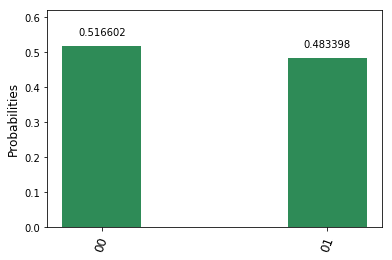

In [98]:
qc_3 = qp.create_circuit('qc_3', [qr], [cr])
# Добавляем гейт Адамара.
qc_3.h(qr[0])
qc_3.measure(qr[0], cr[0])

result = qp.execute('qc_3')
plot_histogram(result.get_counts('qc_3'))

### Вспомогательная цепь

Создадим отдельно квантовую цепь, которая будет состоять из гейта CNOT и измерений.

In [100]:
aux = qp.create_circuit('auxiliary', [qr], [cr])
aux.cx(qr[0], qr[1])

# Измерения.
aux.measure(qr[0], cr[0])
aux.measure(qr[1], cr[1])

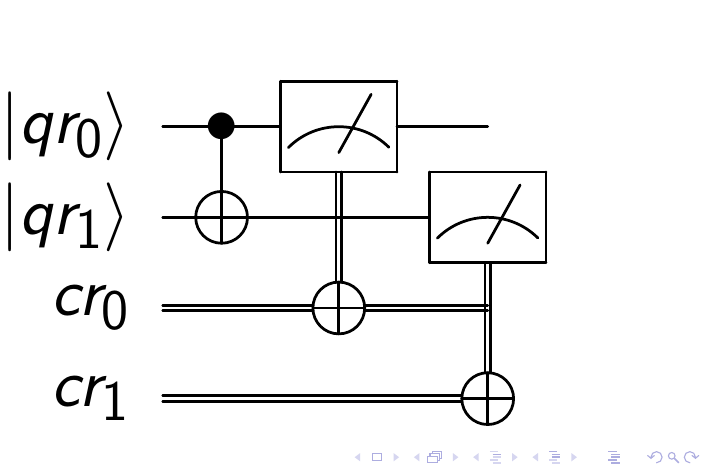

In [101]:
utils.circuitImage(aux, utils.basis)

Вспомним про свойства гейта CNOT:
$$CNOT = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$$

Рассмотрим действие оператора CNOT на двухкубитные состояния:

$CNOT |00\rangle = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$ $\begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \\ \end{pmatrix}$ $= \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \\ \end{pmatrix} = |00\rangle$

$CNOT |01\rangle = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$ $\begin{pmatrix} 0 \\ 1 \\ 0 \\ 0 \\ \end{pmatrix}$ $= \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0 \\ \end{pmatrix} = |01\rangle$

$CNOT |10\rangle = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$ $\begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \\ \end{pmatrix}$ $= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \\ \end{pmatrix} = |11\rangle$

$CNOT |11\rangle = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$ $\begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \\ \end{pmatrix}$ $= \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \\ \end{pmatrix} = |10\rangle$

### Теперь создадим четвёртую цепь

In [135]:
qc_4 = qp.create_circuit('qc_4_begin', [qr], [cr])
qc_4.x(qr[0])
qc_4.x(qr[1])

# Квантовые цепи можно "складывать" вместе, вернее, составлять.
qc_4 = qc_4 + aux

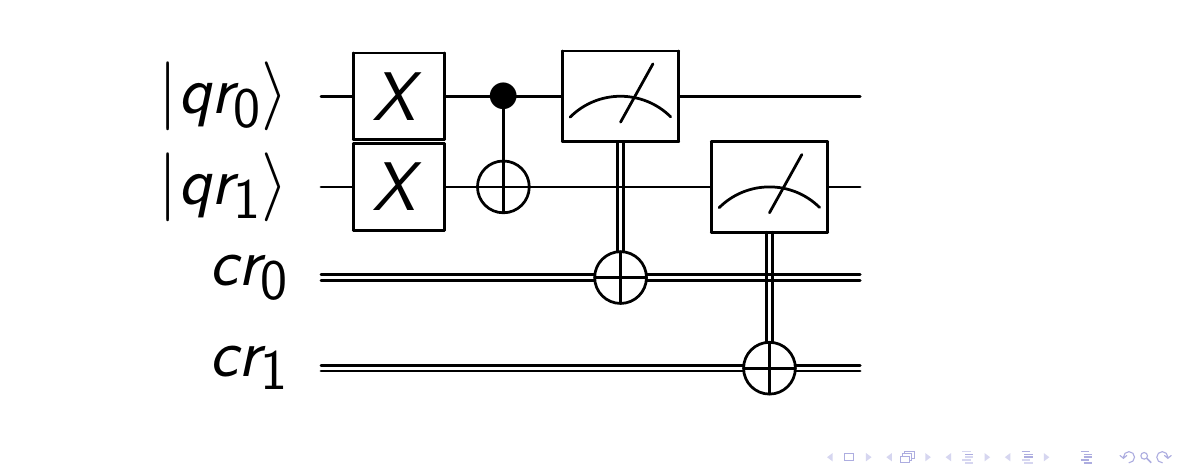

In [136]:
# Таким образом мы получаем четвертую квантовую цепь.
utils.circuitImage(qc_4, utils.basis)

In [137]:
# И записываем её в программу под соответствующим названием.
qp.add_circuit('qc_4', qc_4)

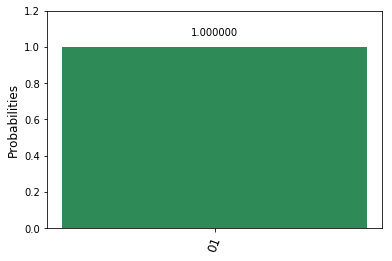

In [138]:
result = qp.execute('qc_4')
plot_histogram(result.get_counts('qc_4'))

### Пятая цепь

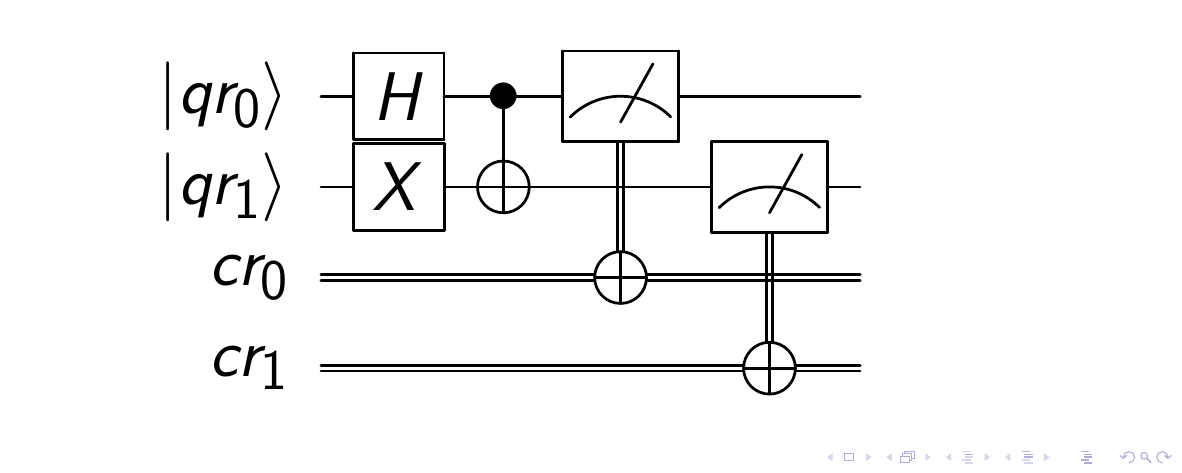

In [111]:
qc_5 = qp.create_circuit('qc_5_begin', [qr], [cr])
qc_5.h(qr[0])
qc_5.x(qr[1])

qc_5 = qc_5 + aux
qp.add_circuit('qc_5', qc_5)

utils.circuitImage(qp.get_circuit('qc_5'), utils.basis)

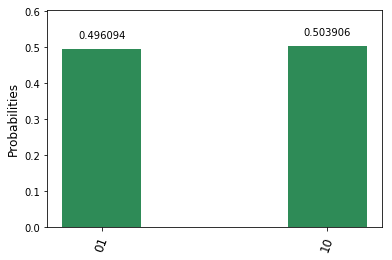

In [112]:
result = qp.execute('qc_5')
plot_histogram(result.get_counts('qc_5'))

## Набор гейтов не ограничивается гейтами H, X, CNOT
Есть ещё много других доступных гейтов, которые включают в себя операторы поворота и т.д.

<div style="text-align: center;"><img src="img/gates.jpg"/><a href="https://github.com/QISKit/qiskit-tutorial/blob/master/1_introduction/beginners_guide_composer_examples.ipynb">Source</a></div>

- [ ] про custom gates
- [ ] assembler representation